In [12]:
# default_exp fontsampler
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Font Sampler

> Utilities to create images from Google Fonts. Code mostly by [@erraticgener8or](https://erraticgenerator.com/blog/use-google-fonts-for-machine-learning-part1/).

In [13]:
#export
from aifont.core import *
import glob
from nbdev.showdoc import *
import numpy as np
import os
import pandas as pd
from pandas import DataFrame
from os.path import basename, join, splitext
from PIL import Image, ImageDraw, ImageFont
import random
import re
from sklearn.preprocessing import MultiLabelBinarizer
from typing import Union

## Rendering Font Images

> Selecting Google Fonts and rendering font images.

In [14]:
#export
GOOGLE_FONT_ROOT_PATH = "data/google_fonts"

def render_text(font_path: str,
    text: str, 
    text_size: int = None, 
    x: int = None, 
    y: int = None, 
    image_width: int = 256, 
    image_height: int = None, 
    as_normalised_array = False
    ) -> Union[
        tuple[np.ndarray, str], tuple[Image.Image, str], tuple[None, None],
        np.ndarray, Image.Image, None
        ]:
    """Render `text` with `font_path` as black on white and return either 
       as a normalised numpy array of (alpha) values or a PIL Image."""
    assert image_width is not None
    if image_height is None: image_height = image_width
    if text_size is None: text_size = round(image_height * .8)
    if x is None: x = image_width * .5
    if y is None:
        # Try to find a nice y location for the text keeping in mind that descenders
        # will reach below this point and might thus fall off canvas
        y = text_size + max(0, (image_height - text_size * 1.5) / 2)
    font = ImageFont.truetype(font_path, text_size)
    # get text info (not being used but may be useful)
    # text_width, text_height = font.getsize(text)
    # left, top, right, bottom = font.getbbox(text)
    # create a blank canvas
    canvas = Image.new('L', (image_width, image_height), 'white')
    # draw the text onto the text canvas
    draw = ImageDraw.Draw(canvas)
    draw.text((x, y), text, 'black', font, anchor='ms')
    # Convert to normalised list if needed
    return np.reshape([(255 - x) / 255. for x in list(canvas.getdata())], (image_height, image_width)) \
           if as_normalised_array else canvas

class FontSampler:
    """Sample Google Fonts and render as images. `df` or `df_path` should point to font annotations
       (see `create_font_annotations`), `font_path` to the root folder of the ofl fonts. Control
       font selection with `variants`, `subsets` and `category`, which can be either strings or 
       regexs. Note that the search is performed on an AND basis meaning that if you define, e.g.,
       `variants=['regular', 'medium']`, you will only find font faces where the family itself
       contains both. Use `add_fonts` with another variant if you want to perform an OR-type
       search."""
    def __init__(self, df: DataFrame = None, df_path: str = f"{GOOGLE_FONT_ROOT_PATH}/google-fonts-annotation.csv", 
        font_path: str = "data/fonts", variants: list[str] = None, subsets: list[str] = None, 
        category: str = None, image_width: int = 256, image_height: int = 256):
        self.df = pd.read_csv(df_path) if df is None else df
        self.font_path = font_path
        self.variants = variants
        self.subsets = subsets
        self.category = category
        self.image_width = image_width
        self.image_height = image_height
        self.font_index = -1
        self.paths = []
        self.set_fonts(self.filter_fonts_get_paths())

    @property
    def num_fonts(self):
        """Get the number of fonts found."""
        return len(self.paths)

    def set_fonts(self, paths: list[str]) -> None:
        """Set paths and shuffle them."""
        self.paths = list(paths)
        random.shuffle(self.paths)
        # Reset index
        self.font_index = -1

    def add_fonts(self, variants: list[str] = None, subsets: list[str] = None, 
        category: str = None) -> None:
        """Add fonts to `self.paths` using the criteria."""
        paths = self.filter_fonts_get_paths(variants=variants, subsets=subsets, category=category)
        paths = list(set(paths + self.paths))
        self.set_fonts(paths)

    def filter_fonts_get_paths(self, variants: list[str] = None, subsets: list[str] = None, 
        category: str = None) -> list[str]:
        """Filter the fonts list by the criteria and return a list of file paths."""
        df = self.df
        font_path = self.font_path
        if variants is None:
            variants = self.variants
        if subsets is None:
            subsets = self.subsets
        if category is None:
            category = self.category
        # exceptions
        if variants is None or variants == [''] or variants == '': 
            variants = ['_']
        if subsets is None or subsets == [''] or subsets == '': 
            subsets = ['_']
        if category is None:
            category = ''
        # apply filters
        regex_filters = variants + subsets + ['_' + category]
        df_new = pd.concat([df.filter(regex=re.compile(regex, re.IGNORECASE), axis=1).sum(axis=1).astype(bool) for regex in regex_filters], axis=1)
        mask = df_new.all(axis=1)
        filtered_fontnames = list(df.loc[mask].family)
        # construct file paths
        paths = []
        for fontname in filtered_fontnames:
            if variants == ['_']: # select all variants
                sel = glob.glob(f'{font_path}/{fontname.lower()}/**/*.ttf', recursive=True)
                paths.extend(sel)
            else:
                for variant in variants:
                    sel = glob.glob(f'{font_path}/{fontname.lower()}/**/{fontname}-{variant}.ttf', recursive=True) 
                    for path in sel:
                        paths.append(path)
        if len(paths) == 0:
            raise Exception("No matching fonts found!")
        # print(f'Found {len(paths)} font files.')
        return paths

    def render_text(self, text: str, text_size: int = None, x: int = None, y: int = None, 
        font_index: int = None, image_width: int = None, image_height: int = None, 
        as_normalised_array = False, include_font = False) -> Union[
            tuple[np.ndarray, str], tuple[Image.Image, str], tuple[None, None],
            np.ndarray, Image.Image, None
            ]:
        """Render the given text as black on white and return either as a normalised 
           numpy array of (alpha) values, a PIL Image or a tuple with one of these and the
           font filename if `include_font` is True. If called without font_index, will 
           iterate over all paths and return None once the end is reached."""
        paths = self.paths
        if font_index is None:
            if self.font_index >= len(paths):
                self.font_index = -1
                return (None, None) if include_font else None
            self.font_index += 1
            font_index = self.font_index
        if text_size is None:    text_size = round(self.image_height * .8)
        if image_width is None:  image_width = self.image_width
        if image_height is None: image_height = self.image_height
        if x is None: x = image_width * .5
        if y is None:
            # Try to find a nice y location for the text keeping in mind that descenders
            # will reach below this point and might thus fall off canvas
            y = text_size + max(0, (image_height - text_size * 1.5) / 2)
        font_path = paths[font_index % len(paths)]
        font = ImageFont.truetype(font_path, text_size)
        # get text info (not being used but may be useful)
        # text_width, text_height = font.getsize(text)
        # left, top, right, bottom = font.getbbox(text)
        # print(left, top, right, bottom)
        # create a blank canvas
        canvas = Image.new('L', (image_width, image_height), 'white')
        # draw the text onto the text canvas
        draw = ImageDraw.Draw(canvas)
        draw.text((x, y), text, 'black', font, anchor='ms')
        # Convert to normalised list if needed
        img = np.reshape([(255 - x) / 255. for x in list(canvas.getdata())],
                         (image_height, image_width)) if as_normalised_array else canvas
        # Include  font name if needed
        if include_font: return (img, basename(font_path))
        return img


In [15]:
show_doc(FontSampler.num_fonts)
show_doc(FontSampler.render_text)

<h4 id="FontSampler.num_fonts" class="doc_header"><code>FontSampler.num_fonts</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Get the number of fonts found.

<h4 id="FontSampler.render_text" class="doc_header"><code>FontSampler.render_text</code><a href="__main__.py#L90" class="source_link" style="float:right">[source]</a></h4>

> <code>FontSampler.render_text</code>(**`text`**:`str`, **`text_size`**:`int`=*`None`*, **`x`**:`int`=*`None`*, **`y`**:`int`=*`None`*, **`font_index`**:`int`=*`None`*, **`image_width`**:`int`=*`None`*, **`image_height`**:`int`=*`None`*, **`as_normalised_array`**=*`False`*, **`include_font`**=*`False`*)

Render the given text as black on white and return either as a normalised 
numpy array of (alpha) values, a PIL Image or a tuple with one of these and the
font filename if `include_font` is True. If called without font_index, will 
iterate over all paths and return None once the end is reached.

Render a letter as a grayscale image.

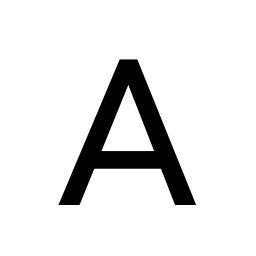

In [16]:
fs = FontSampler(category="sans-serif")
img = fs.render_text('A'); img

Or as a numpy matrix.

In [17]:
np_img = fs.render_text('A', as_normalised_array=True, font_index=0)
np_img.shape

(256, 256)

To use it with `diffvg`, use the values as the A-band of the RGBA tensors.

In [18]:
import torch
import torch.nn.functional as F

wd_ht = torch.tensor(np_img, dtype=torch.float32)
wd_ht_a = torch.reshape(wd_ht, wd_ht.shape + tuple([1]))
wd_ht_rgba = F.pad(input=wd_ht_a, pad=(3, 0, 0, 0, 0, 0), mode='constant', value=0)
wd_ht.shape, wd_ht_a.shape, wd_ht_rgba.shape

(torch.Size([256, 256]), torch.Size([256, 256, 1]), torch.Size([256, 256, 4]))

In [19]:
show_doc(FontSampler.add_fonts)

<h4 id="FontSampler.add_fonts" class="doc_header"><code>FontSampler.add_fonts</code><a href="__main__.py#L38" class="source_link" style="float:right">[source]</a></h4>

> <code>FontSampler.add_fonts</code>(**`variants`**:`list`\[`str`\]=*`None`*, **`subsets`**:`list`\[`str`\]=*`None`*, **`category`**:`str`=*`None`*)

Add fonts to `self.paths` using the criteria.

## Creating Font Samples

> Using FontSampler to create a set of font images for use in learning.

In [20]:
#export
def create_font_images(texts = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"), 
    variants = ["regular", "medium", "light"], file_extension = ".png",
    image_width = 256, image_height = 256, out_path = f"{GOOGLE_FONT_ROOT_PATH}/font_images") -> None:
    """Create font images and save them. Find matching font `variants` and
       renders grayscale `image_width` x `image_height` images for each
       of the `texts` using `FontSampler.render_text`."""

    fs = FontSampler(category="sans-serif", 
                    subsets=["latin"],
                    variants=[variants[0]] if len(variants) > 0 else None,
                    image_width=image_width,
                    image_height=image_height)

    if len(variants) > 1:
        for v in variants[1:]:
            fs.add_fonts(category="sans-serif",
                        subsets=["latin"],
                        variants=[v])

    print(f"{fs.num_fonts} fonts found.")

    for i in range(fs.num_fonts):
        if i % 20 == 0: print(f"Font {i}/{fs.num_fonts}")
        for t in texts:
            img, font = fs.render_text(t, 
                                       font_index=i,
                                       include_font=True)
            font = splitext(font)[0]
            filename = join(out_path, f"{t}_{font}{file_extension}")
            try:
                img.save(filename)
            except Exception as e:
                print(f"Error with {font} / {t}: {e}")
    
    print("Done")


## Getting Font Metadata

> Get font metadata from the Google Fonts API. Needed only once. You need an API key for this.

In [21]:
#export 
def create_font_annotations(data_path: str = os.path.join(GOOGLE_FONT_ROOT_PATH, "webfonts.json"), api_key: str = None, 
    save_path = "data/google-fonts-annotation.csv") -> DataFrame:
    """Get Google Fonts metadata either from the API using `api_key` or from
       a local file at `data_path` and save the data as csv in `save_path`.
       Also returns the data frame."""

    assert api_key is not None or data_path is not None

    if data_path is not None:
        # Use JSON already downloaded
        df = pd.read_json(data_path)
    else:
        # Download json data once
        url = f"https://www.googleapis.com/webfonts/v1/webfonts?key={api_key}"
        df = pd.read_json(url, orient='')

    # flatten the JSON hierarchy (easier to handle this way)
    df = pd.json_normalize(df['items'])

    # select only the columns we need
    cols = ['family', 'variants', 'subsets', 'category']
    df = df[cols]
    # df.head(5)

    # Remove any space from family string so that it matchs with file name convention.
    df.family = [name.replace(' ', '') for name in df.family]

    mlb = MultiLabelBinarizer()

    # one-hot encoding + prefix
    df = df.join(DataFrame(mlb.fit_transform(df.pop('variants')),
                           columns=[x for x in mlb.classes_],
                           index=df.index))
    df = df.join(DataFrame(mlb.fit_transform(df.pop('subsets')),
                           columns=['subsets_' + x for x in mlb.classes_],
                           index=df.index))
    df = df.join(pd.get_dummies(df['category'], prefix="category")).drop(['category'], axis=1)

    col_names = {
        "100": "thin",
        "100italic": "thinitalic",
        "200": "extralight",
        "200italic": "extralightitalic",
        "300": "light",
        "300italic": "lightitalic",
        "400": "regular",
        "regular": "regular",
        "400italic": "italic",
        "italic": "italic",
        "500": "medium",
        "500italic": "mediumitalic",
        "600": "semibold",
        "600italic": "semibolditalic",
        "700": "bold",
        "700italic": "bolditalic",
        "800": "extrabold",
        "800italic": "extrabolditalic",
        "900": "black",
        "900italic": "blackitalic"
    }
    col_names = {k:f'variants_{v}' for k, v in col_names.items()}

    df = df.rename(col_names, axis='columns')

    # Export csv
    if not save_path.endswith(".csv"):
        save_path += ".csv"
    df.to_csv(save_path, index=False)

    return df

## Export

In [1]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 01_fontlearnertests.ipynb.
Converted 02_first_letter_and_optim_tests.ipynb.
Converted 03_vector_models.ipynb.
Converted 04_font_statistics.ipynb.
Converted 05_full_aphabet_optimisation.ipynb.
Converted 06_data_augmentation.ipynb.
Converted 07_optimising_with_augmentation.ipynb.
Converted aifont_core.ipynb.
Converted aifont_fontlearner.ipynb.
Converted aifont_fontsampler.ipynb.
Converted aifont_ocrlearner.ipynb.
Converted index.ipynb.
